# Youtube Comment Sentiment Analysis

by Rahma Hayuning Astuti

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# read dataset
df = pd.read_csv('./data/youtube-comments-dataset.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [4]:
# change to lowercase
df.columns = df.columns.str.lower()
df.head()

,comment,sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


## EDA

In [5]:
df.dtypes

comment      object
sentiment    object
dtype: object

In [6]:
df.describe()

,comment,sentiment
count,18364,18408
unique,17871,3
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


In [7]:
#check for missing value
df.isna().sum()

comment      44
sentiment     0
dtype: int64

In [8]:
#delete the missing value, since it's only a few
df = df.dropna()

In [9]:
df.isna().sum()

comment      0
sentiment    0
dtype: int64

In [10]:
df.head()

,comment,sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [11]:
# check data distribution

temp = df.groupby('sentiment').count()['comment'].reset_index().sort_values(by='sentiment', ascending=False)
temp.style.background_gradient(cmap='Reds')


,sentiment,comment
2,positive,11402
1,neutral,4625
0,negative,2337


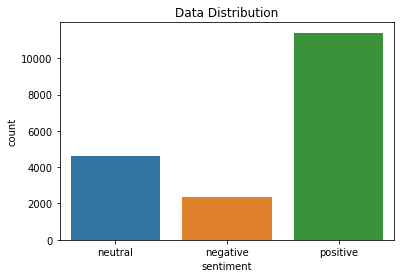

In [12]:
sns.countplot(x=df['sentiment'])
plt.title('Data Distribution')
plt.show()

most common words

In [13]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenizing words and removing stopwords
def get_most_common_words(texts, n=20):
    words = " ".join(texts).lower().split()
    words = [word for word in words if word not in stop_words]  
    return Counter(words).most_common(n)

# Get most frequent words
positive_words = get_most_common_words(df[df['sentiment'] == 'positive']['comment'])
negative_words = get_most_common_words(df[df['sentiment'] == 'negative']['comment'])

print("Most common words in positive reviews:", positive_words)
print("Most common words in negative reviews:", negative_words)


Most common words in positive reviews: [('love', 1960), ('like', 1621), ('video', 1499), ('thank', 1440), ('great', 1366), ('really', 1291), ('one', 1272), ('much', 1175), ('good', 1144), ('im', 1059), ('videos', 984), ('time', 950), ('get', 825), ('always', 809), ('thanks', 806), ('best', 751), ('see', 746), ('would', 738), ('amazing', 699), ('make', 637)]
Most common words in negative reviews: [('like', 428), ('people', 372), ('one', 279), ('would', 263), ('get', 246), ('even', 242), ('dont', 228), ('time', 217), ('im', 213), ('know', 210), ('really', 180), ('think', 168), ('much', 151), ('never', 146), ('make', 144), ('years', 142), ('way', 139), ('see', 135), ('still', 134), ('want', 132)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


find text length

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


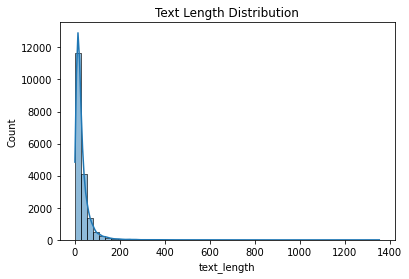

In [27]:
df['text_length'] = df['comment'].apply(lambda x: len(x.split()))

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.show()


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# create the transform
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['Comment'])

# summarize encoded vector
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

print('Most common words:', sorted_word_freq[:20])

Most common words: [('like', 2631), ('just', 2588), ('love', 2152), ('video', 1944), ('really', 1648), ('time', 1544), ('thank', 1511), ('great', 1503), ('im', 1490), ('good', 1412), ('people', 1255), ('videos', 1085), ('know', 1079), ('make', 1037), ('best', 904), ('thanks', 867), ('game', 861), ('way', 858), ('think', 857), ('dont', 848)]


In [29]:
from nltk.util import ngrams

# Function to extract n-grams
def get_ngrams(word_list, n=2):
    return list(ngrams(word_list, n))

# Get bigrams for negative comments
negative_bigrams = get_ngrams(negative_words, n=2)
print("Top Negative Bigrams:", Counter(negative_bigrams).most_common(5))
positive_bigrams = get_ngrams(positive_words, n=2)
print("Top Positive Bigrams:", Counter(positive_bigrams).most_common(5))

Top Negative Bigrams: [((('like', 428), ('people', 372)), 1), ((('people', 372), ('one', 279)), 1), ((('one', 279), ('would', 263)), 1), ((('would', 263), ('get', 246)), 1), ((('get', 246), ('even', 242)), 1)]
Top Positive Bigrams: [((('love', 1960), ('like', 1621)), 1), ((('like', 1621), ('video', 1499)), 1), ((('video', 1499), ('thank', 1440)), 1), ((('thank', 1440), ('great', 1366)), 1), ((('great', 1366), ('really', 1291)), 1)]


### correlation of word and sentiment

In [35]:
#encode the label

from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels into numbers
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])


In [36]:
df.head()

,comment,sentiment,text_length,emojis
0,lets not forget that apple pay in 2014 require...,1,57,
1,here in nz 50 of retailers don’t even have con...,0,29,
2,i will forever acknowledge this channel with t...,2,31,
3,whenever i go to a place that doesn’t take app...,0,83,
4,apple pay is so convenient secure and easy to ...,2,26,


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get TF-IDF scores for words
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["comment"])
feature_names = tfidf.get_feature_names_out()

# Correlation with sentiment (1=positive, 0=negative)
df_tfidf = pd.DataFrame(X.toarray(), columns=feature_names)
df_tfidf["sentiment"] = df["sentiment"]

# Words most correlated with positive sentiment
correlations = df_tfidf.corr()["sentiment"].sort_values(ascending=False)
print("Top Positive Correlated Words:", correlations.head(10))
print("Top Negative Correlated Words:", correlations.tail(10))

Top Positive Correlated Words: sentiment    1.000000
song         0.035464
love         0.035053
data         0.032489
you          0.031852
machine      0.029814
this         0.028492
courses      0.027819
thanks       0.027403
music        0.026190
Name: sentiment, dtype: float64
Top Negative Correlated Words: solved      -0.026230
their       -0.026291
country     -0.031401
issue       -0.031945
he          -0.032313
law         -0.033004
they        -0.034852
people      -0.036590
trump       -0.048652
documents   -0.054534
Name: sentiment, dtype: float64


In [39]:
df.head()

,comment,sentiment,text_length
0,lets not forget that apple pay in 2014 require...,1,57
1,here in nz 50 of retailers don’t even have con...,0,29
2,i will forever acknowledge this channel with t...,2,31
3,whenever i go to a place that doesn’t take app...,0,83
4,apple pay is so convenient secure and easy to ...,2,26


## Train-test Split

In [42]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [56]:
# separate X and y
# X= "Comment" only
X = df['comment'] 

# Target (y) = "sentiment" column
y = df["sentiment"]               # y is a Series

In [57]:
#split the dataset

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [58]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (14691,)
y_train shape: (14691,)
X_test shape: (3673,)
y_test shape: (3673,)


In [59]:
# make sure to X_train and X_test are dataframes
X_train = X_train.to_frame()  # Convert Series to DataFrame
X_test = X_test.to_frame()    # Convert Series to DataFrame

In [64]:
# checking the shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (14691, 1)
y_train shape: (14691,)


In [65]:
print("Type of X_train:", type(X_train))  # Should be <class 'pandas.core.frame.DataFrame'>
print("X_train shape:", X_train.shape)    # Should be (9794, 1)

Type of X_train: <class 'pandas.core.frame.DataFrame'>
X_train shape: (14691, 1)


## Training the Model

first let's train the classic model

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [67]:
# models and their hyperparameter grids


models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        "clf__C": [0.1, 1, 10], 
        "clf__penalty": ["l1", "l2"]  
    }),
    
    "Random Forest": (RandomForestClassifier(), {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [None, 10, 20]
    }),
    
    "SVM": (SVC(), {
        "clf__C": [0.1, 1, 10], 
        "clf__kernel": ["linear", "rbf"]
    })
}


In [68]:
# save the results and run the model

results = {}
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    
    # Define pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()), 
        ("clf", model)
    ])
    
    # Hyperparameter tuning
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_grid, 
        n_iter=5, 
        cv=3, 
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train['comment'], y_train)
    
    # Store results
    results[model_name] = {
        "Best Params": search.best_params_,
        "Best Accuracy": search.best_score_
    }

# Print results for all models
for model, res in results.items():
    print(f"\n{model}:")
    print(f"  Best Hyperparameters: {res['Best Params']}")
    print(f"  Best Accuracy: {res['Best Accuracy']:.4f}")

Training Logistic Regression...


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\skle

Training Random Forest...
Training SVM...

Logistic Regression:
  Best Hyperparameters: {'clf__penalty': 'l2', 'clf__C': 10}
  Best Accuracy: 0.7501

Random Forest:
  Best Hyperparameters: {'clf__n_estimators': 100, 'clf__max_depth': None}
  Best Accuracy: 0.6887

SVM:
  Best Hyperparameters: {'clf__kernel': 'rbf', 'clf__C': 10}
  Best Accuracy: 0.7512


evaluate on test data

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

C:\Users\asus\AppData\Local\Temp/ipykernel_6500/827955304.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


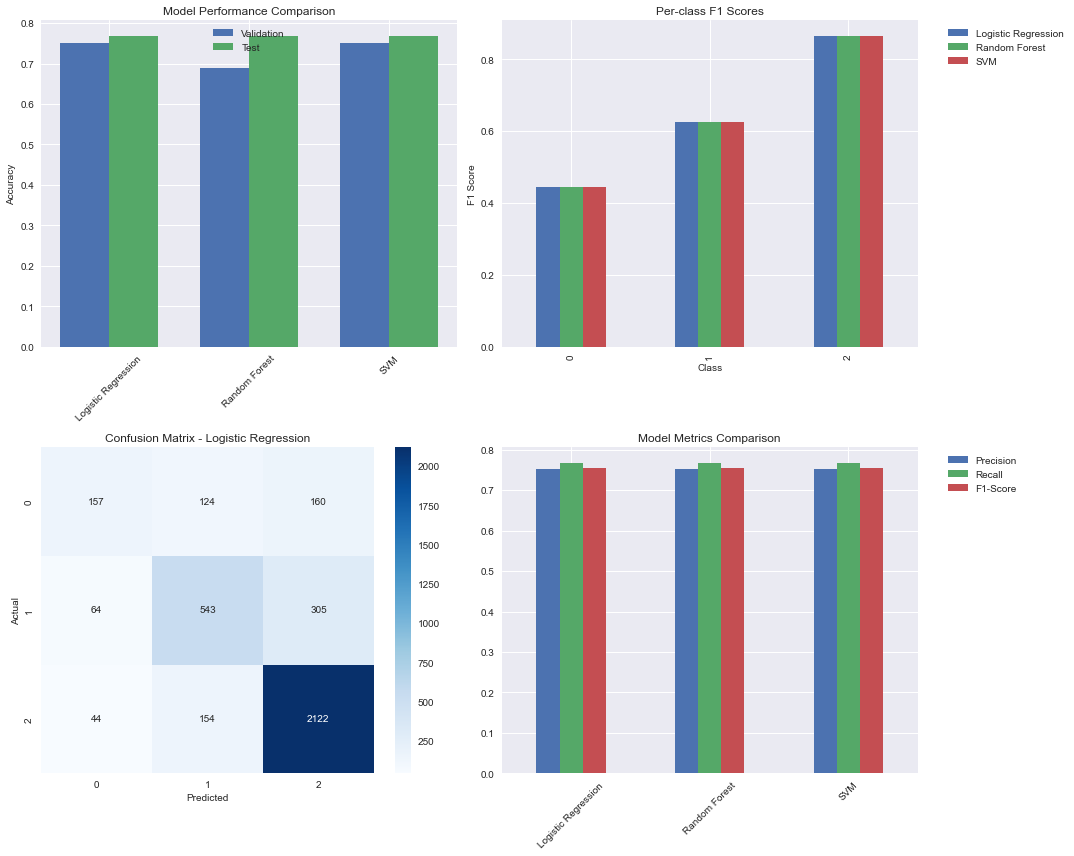


=== Logistic Regression Test Results ===

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.44       441
           1       0.66      0.60      0.63       912
           2       0.82      0.91      0.86      2320

    accuracy                           0.77      3673
   macro avg       0.69      0.62      0.65      3673
weighted avg       0.75      0.77      0.76      3673


=== Random Forest Test Results ===

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.44       441
           1       0.66      0.60      0.63       912
           2       0.82      0.91      0.86      2320

    accuracy                           0.77      3673
   macro avg       0.69      0.62      0.65      3673
weighted avg       0.75      0.77      0.76      3673


=== SVM Test Results ===

Classification Report:
              precision    recall  f1-score   support

       

In [80]:
test_results = {}

# Evaluate each model on test set
for model_name, (model, _) in models.items():
    # Get the best model from grid search
    best_model = search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test['comment'])
    
    # Store results
    test_results[model_name] = {
        "predictions": y_pred,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "accuracy": best_model.score(X_test['comment'], y_test)
    }

# Create visualizations
plt.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bar plot of accuracies
accuracies = {model: results["Best Accuracy"] for model, results in results.items()}
test_accuracies = {model: res["accuracy"] for model, res in test_results.items()}

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, accuracies.values(), width, label='Validation')
ax1.bar(x + width/2, test_accuracies.values(), width, label='Test')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models.keys(), rotation=45)
ax1.legend()

# 2. Per-class accuracy for each model
class_results = {}
for model_name, res in test_results.items():
    report_dict = classification_report(y_test, res["predictions"], output_dict=True)
    class_results[model_name] = {str(cls): metrics['f1-score'] 
                                for cls, metrics in report_dict.items() 
                                if cls.isdigit()}  # Only get class results, not averages

df_class = pd.DataFrame(class_results)
df_class.plot(kind='bar', ax=ax2)
ax2.set_title('Per-class F1 Scores')
ax2.set_xlabel('Class')
ax2.set_ylabel('F1 Score')
ax2.legend(bbox_to_anchor=(1.05, 1))

# 3. Confusion Matrix for best model
best_model_name = max(test_accuracies, key=test_accuracies.get)
best_cm = test_results[best_model_name]["confusion_matrix"]

sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'Confusion Matrix - {best_model_name}')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Model Metrics Comparison
model_metrics = {}
for model_name, res in test_results.items():
    report_dict = classification_report(y_test, res["predictions"], output_dict=True)
    model_metrics[model_name] = {
        'Precision': report_dict['weighted avg']['precision'],
        'Recall': report_dict['weighted avg']['recall'],
        'F1-Score': report_dict['weighted avg']['f1-score']
    }

metrics_df = pd.DataFrame(model_metrics).T
metrics_df.plot(kind='bar', ax=ax4)
ax4.set_title('Model Metrics Comparison')
ax4.set_xticklabels(metrics_df.index, rotation=45)
ax4.legend(bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Print detailed results
for model_name, res in test_results.items():
    print(f"\n=== {model_name} Test Results ===")
    print("\nClassification Report:")
    print(res["classification_report"])

will use SVM for the model